In [ ]:
# From
# https://colab.research.google.com/github/dattalab/keypoint-moseq/blob/main/docs/keypoint_moseq_colab.ipynb

In [39]:
import keypoint_moseq as kpms
import numpy as np
from pathlib import Path

In [11]:
# Input data - if SLEAP, it needs to be SLEAP H5 FILE
# data_dir='/home/sminano/swc/project_teaching_behaviour/mouse-EPM/derivatives/behav/software-SLEAP_project/predictions/video-1.predictions.slp'
# sleap_file='video-1.predictions.slp'
# sleap_file = os.path.join(data_dir, sleap_file) 
# sleap_predictions = '/home/sminano/swc/project_teaching_behaviour/mouse-EPM/derivatives/behav/software-SLEAP_project/predictions/video-1.predictions.slp'
sleap_predictions = '/home/sminano/swc/project_teaching_behaviour/mouse-EPM/derivatives/behav/software-SLEAP_project/predictions/video-1.predictions.analysis.h5'
video_path = '/home/sminano/swc/project_teaching_behaviour/mouse-EPM/rawdata/sub-01_id-M708149/ses-01_date-20200317/behav/sub-01_ses-01_task-EPM_time-165049_video.mp4'

In [12]:
# Create moseq project
project_dir = '/home/sminano/swc/project_teaching_behaviour/mouse-EPM-moseq' # must not exist before
config = lambda: kpms.load_config(project_dir)

# from SLEAP
# choose a .h5 file for one of your recordings
kpms.setup_project(project_dir, sleap_file=sleap_predictions) # this creates a config file

The directory `/home/sminano/swc/project_teaching_behaviour/mouse-EPM-
moseq` already exists. Use `overwrite=True` or pick a different name


In [13]:
# Edit config
kpms.update_config(
    project_dir,
    video_dir=str(Path(video_path).parent),
    anterior_bodyparts=['snout', 'left_ear', 'right_ear'],  # used to initialize heading
    posterior_bodyparts=['tail_base'], # used to initialize heading
    # use_bodyparts= # determines the subset of bodyparts to use for modeling and the order in which they are represented
)

In [14]:
# Load keypoints and preprocess
coordinates, confidences, bodyparts = kpms.load_keypoints(sleap_predictions, 'sleap')

# format data for modeling
data, metadata = kpms.format_data(coordinates, confidences, **config())

Loading keypoints: 100%|██████████████████| 1/1 [00:00<00:00, 42.70it/s]


>=90.0% of variance exlained by 3 components.


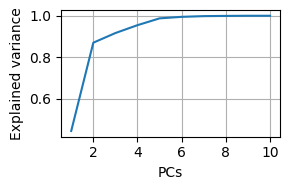

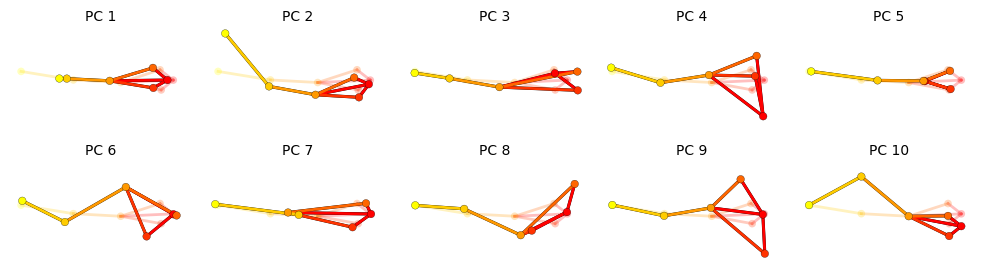

In [21]:
# Calibration regression --- skip

# Fit PCA
pca = kpms.fit_pca(**data, **config())

kpms.save_pca(pca, project_dir)  # saves it to the project

# visualise results
kpms.print_dims_to_explain_variance(pca, 0.9)
kpms.plot_scree(pca, project_dir=project_dir)
kpms.plot_pcs(pca, project_dir=project_dir, **config())

# save number of dimensions to keep
kpms.update_config(project_dir, latent_dim=4)

In [17]:
# Overview model fitting
# 1. Random initialisation
# 2. Fit an AR-HMM
# 3. Fit full model
# 4. Extract model results

# Setting kappa


In [25]:
# 1. Randomly initialize the model
model = kpms.init_model(data, pca=pca, **config())

# optionally modify kappa
# model = kpms.update_hypparams(model, kappa=NUMBER)

Outputs will be saved to
/home/sminano/swc/project_teaching_behaviour/mouse-EPM-
moseq/2024_08_16-15_21_45


  0%|                                           | 0/101 [00:00<?, ?it/s]

 25%|████████▍                         | 25/101 [00:23<01:11,  1.06it/s]

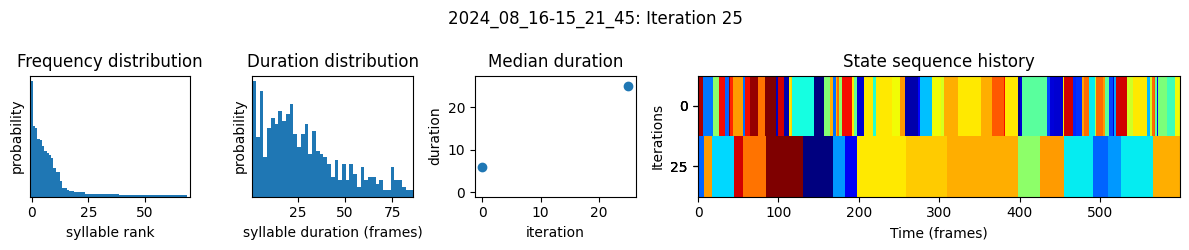

 50%|████████████████▊                 | 50/101 [00:47<00:47,  1.06it/s]

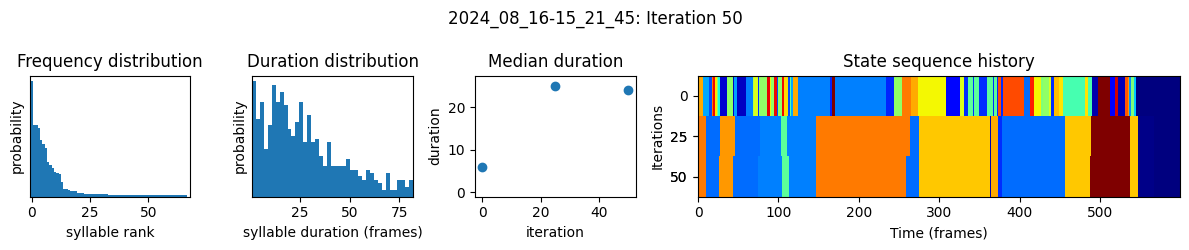

 74%|█████████████████████████▏        | 75/101 [01:11<00:24,  1.06it/s]

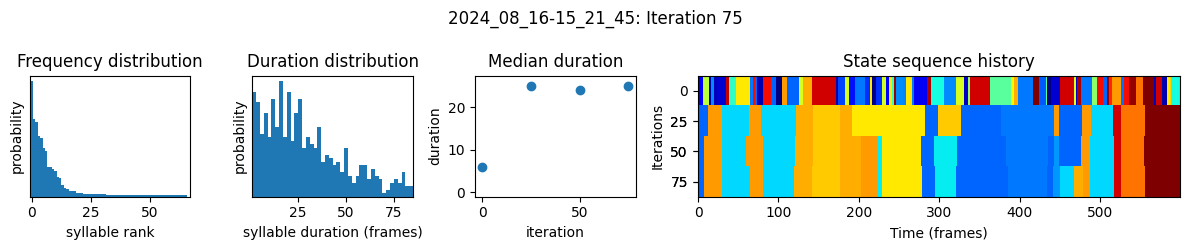

 99%|████████████████████████████████▋| 100/101 [01:34<00:00,  1.06it/s]

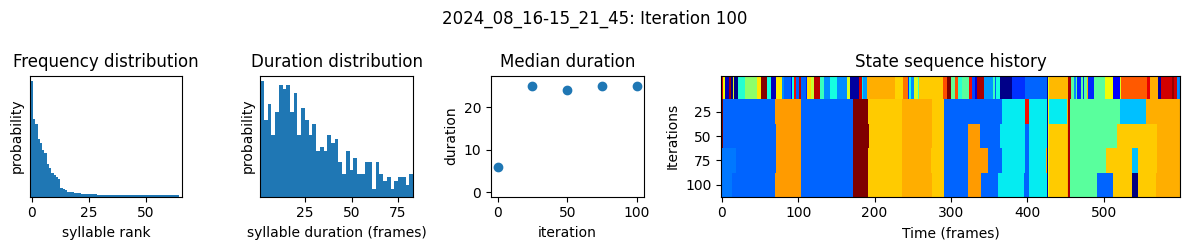

100%|█████████████████████████████████| 101/101 [01:35<00:00,  1.05it/s]


In [26]:
# 2. Fit AR-HMM
num_ar_iters = 100

model, model_name = kpms.fit_model(
    model, data, metadata, project_dir,
    ar_only=True, num_iters=num_ar_iters
)

Outputs will be saved to
/home/sminano/swc/project_teaching_behaviour/mouse-EPM-
moseq/2024_08_16-15_21_45


  5%|█▋                                | 25/501 [00:35<07:52,  1.01it/s]

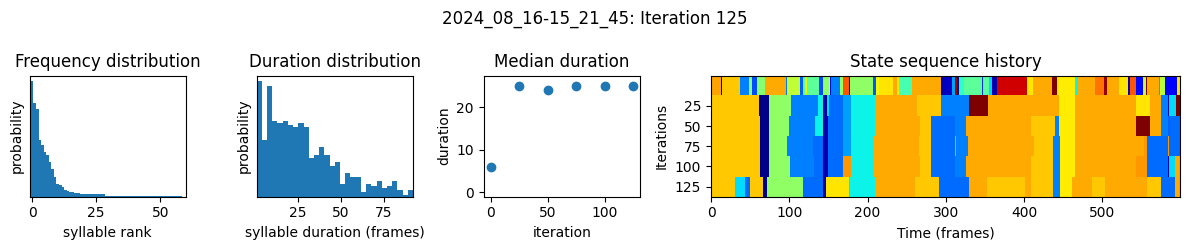

 10%|███▍                              | 50/501 [01:00<07:27,  1.01it/s]

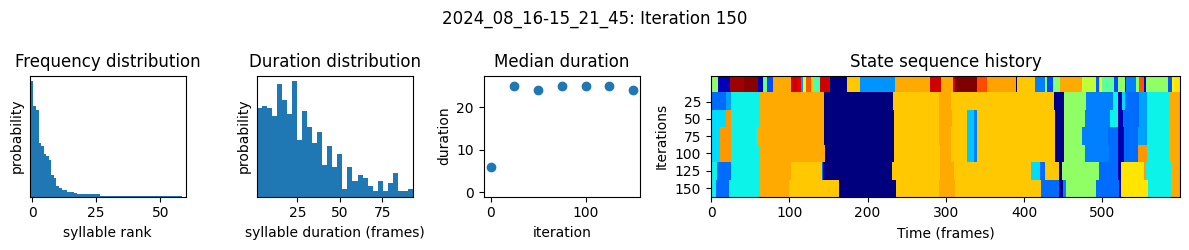

 15%|█████                             | 75/501 [01:25<07:03,  1.01it/s]

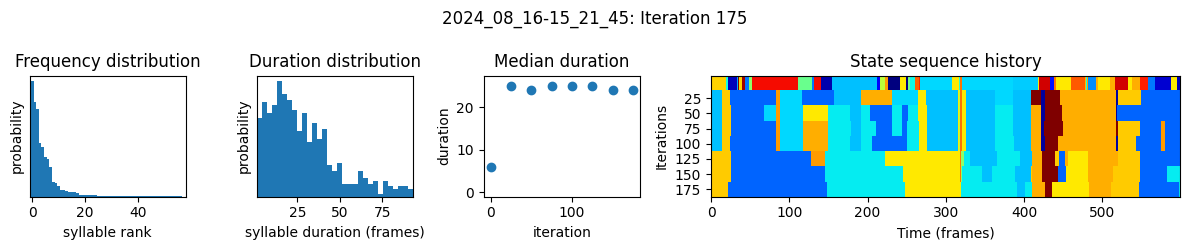

 20%|██████▌                          | 100/501 [01:50<06:37,  1.01it/s]

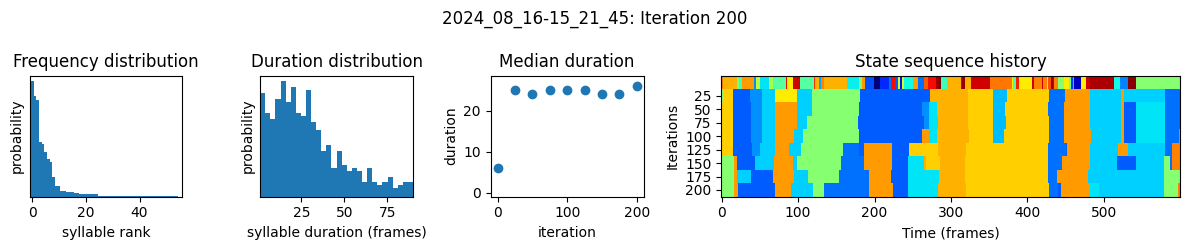

 25%|████████▏                        | 125/501 [02:15<06:13,  1.01it/s]

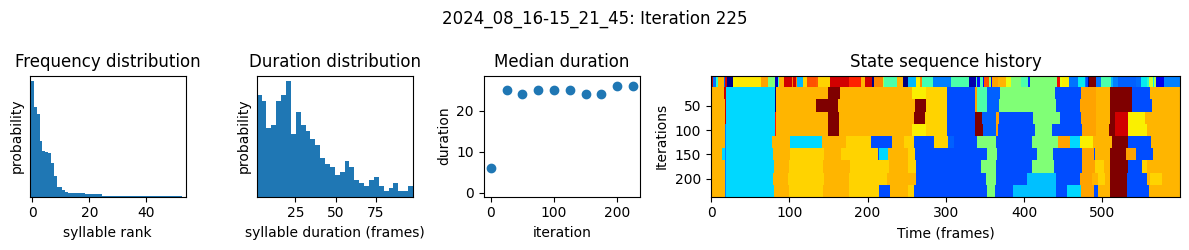

 30%|█████████▉                       | 150/501 [02:40<05:48,  1.01it/s]

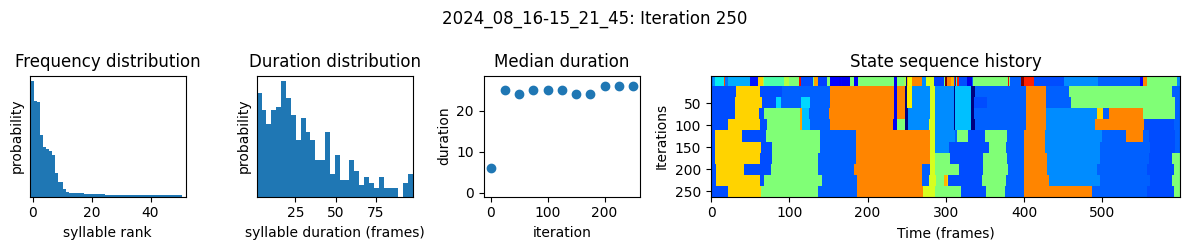

 35%|███████████▌                     | 175/501 [03:05<05:24,  1.00it/s]

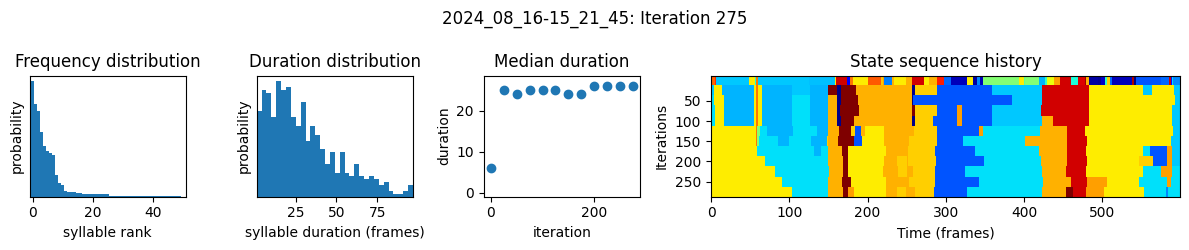

 40%|█████████████▏                   | 200/501 [03:30<04:59,  1.00it/s]

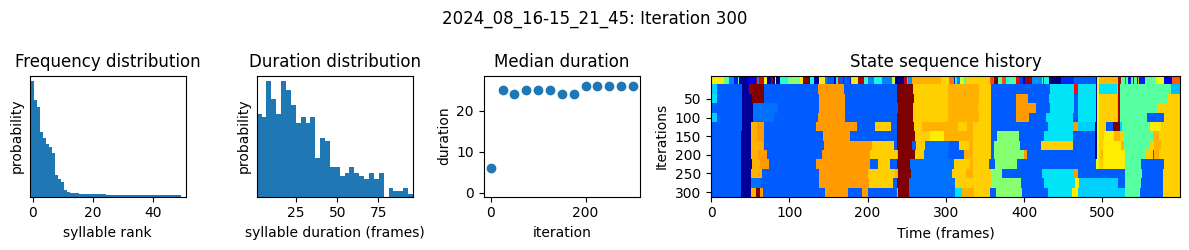

 45%|██████████████▊                  | 225/501 [03:55<04:35,  1.00it/s]

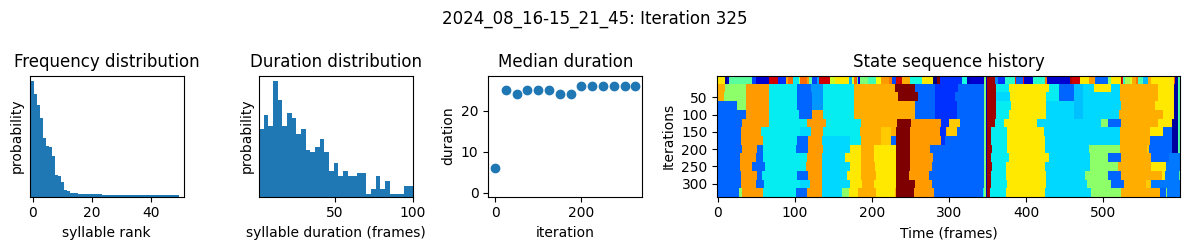

 50%|████████████████▍                | 250/501 [04:20<04:10,  1.00it/s]

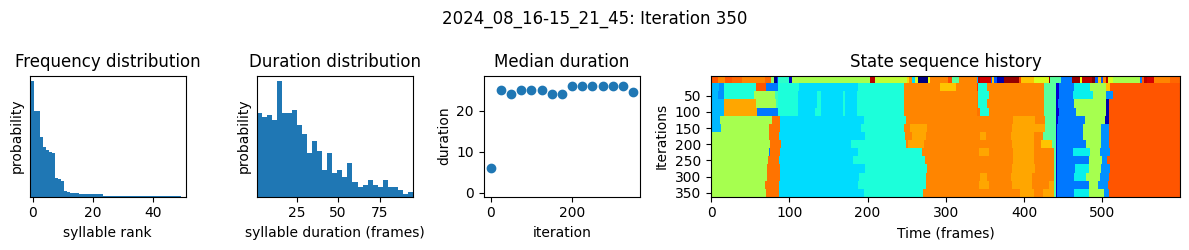

 55%|██████████████████               | 275/501 [04:46<03:45,  1.00it/s]

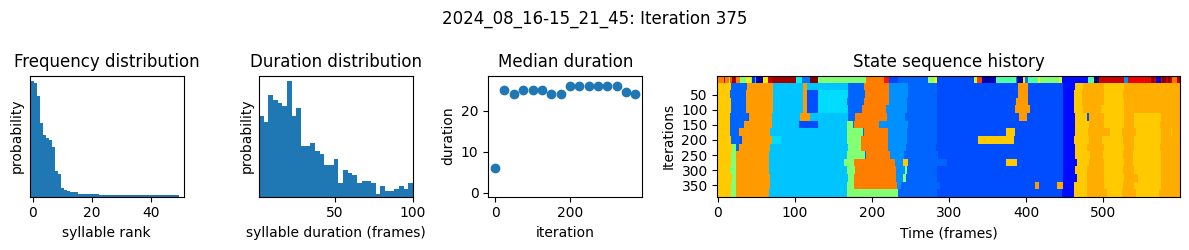

 60%|███████████████████▊             | 300/501 [05:11<03:20,  1.00it/s]

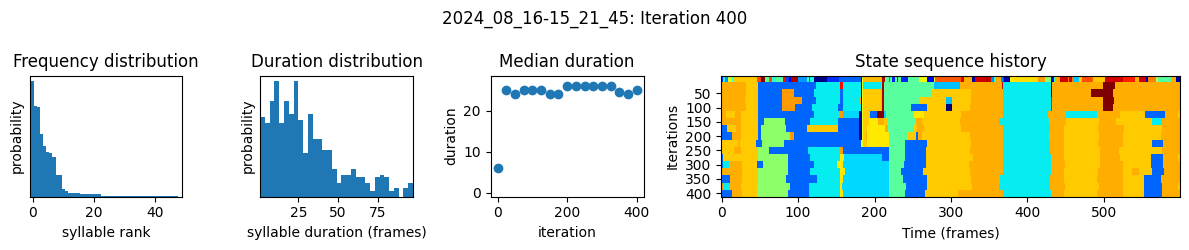

 65%|█████████████████████▍           | 325/501 [05:36<02:55,  1.00it/s]

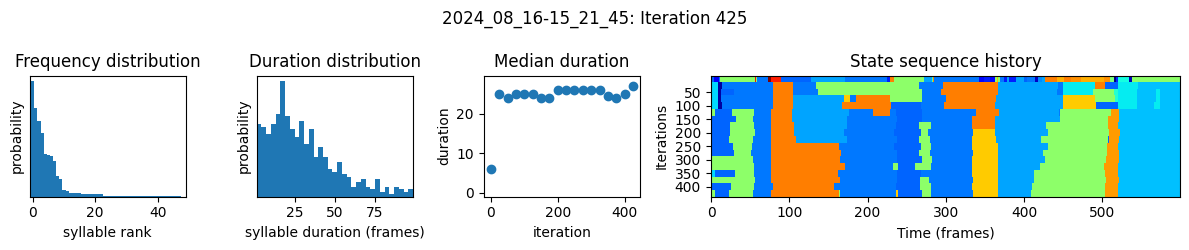

 70%|███████████████████████          | 350/501 [06:01<02:30,  1.00it/s]

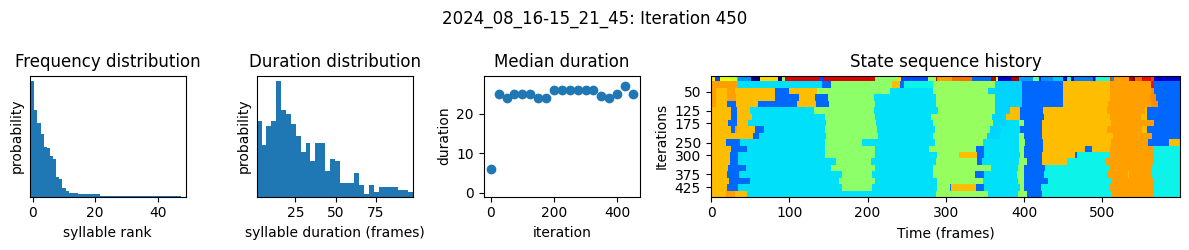

 75%|████████████████████████▋        | 375/501 [06:26<02:05,  1.00it/s]

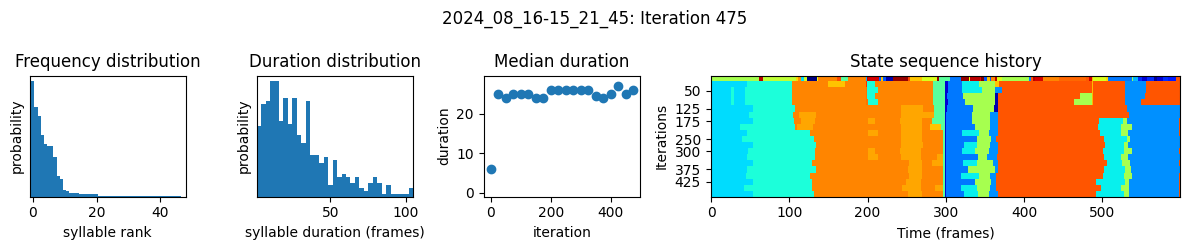

 80%|██████████████████████████▎      | 400/501 [06:51<01:40,  1.00it/s]

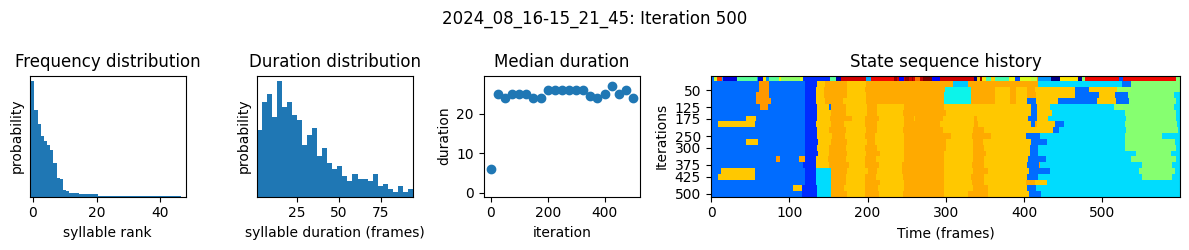

 85%|███████████████████████████▉     | 425/501 [07:16<01:15,  1.00it/s]

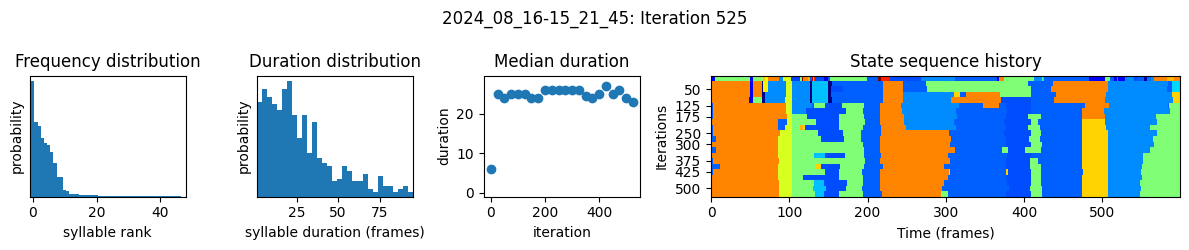

 90%|█████████████████████████████▋   | 450/501 [07:41<00:50,  1.00it/s]

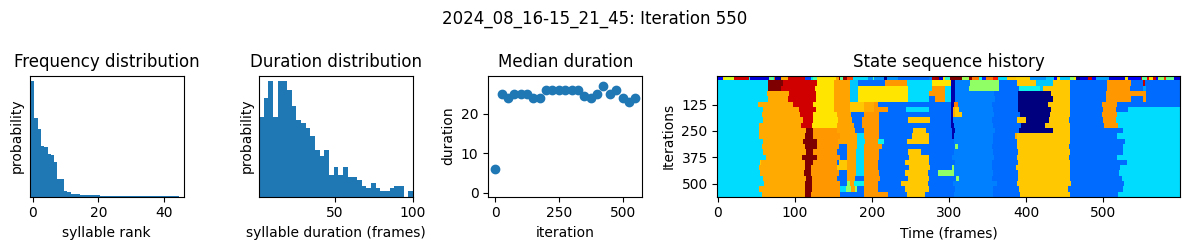

 95%|███████████████████████████████▎ | 475/501 [08:07<00:25,  1.00it/s]

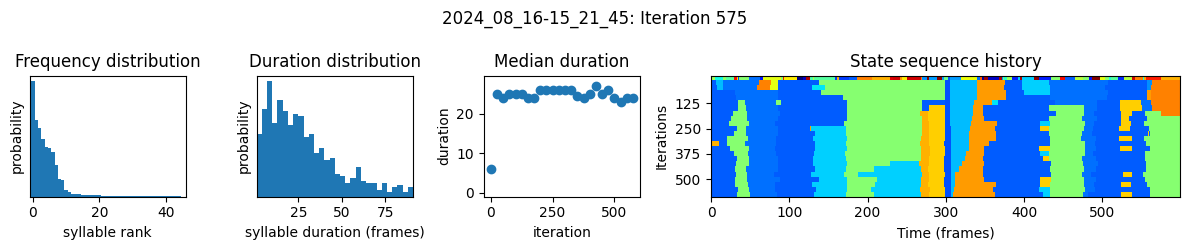

100%|████████████████████████████████▉| 500/501 [08:32<00:00,  1.00it/s]

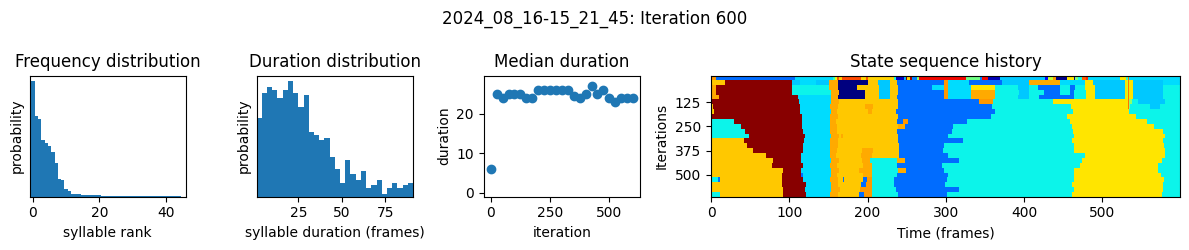

100%|█████████████████████████████████| 501/501 [08:33<00:00,  1.02s/it]


In [27]:
# 3. Fit full model
# You may need to try a few values of kappa

# load model checkpoint
model, data, metadata, current_iter = kpms.load_checkpoint(
    project_dir, model_name, iteration=num_ar_iters
)

# modify kappa to maintain the desired syllable time-scale
model = kpms.update_hypparams(model, kappa=1e4)

# run fitting for an additional 500 iters
model = kpms.fit_model(
    model, data, metadata, project_dir, model_name, ar_only=False, 
    start_iter=current_iter, num_iters=current_iter+500
)[0]
    

In [30]:
# 4. Extract model results

# modify a saved checkpoint so syllables are ordered by frequency
kpms.reindex_syllables_in_checkpoint(project_dir, model_name)

# load the most recent model checkpoint
model, data, metadata, current_iter = kpms.load_checkpoint(project_dir, model_name)

# extract results
results = kpms.extract_results(model, metadata, project_dir, model_name)

# optionally save results as csv
kpms.save_results_as_csv(results, project_dir, model_name)

Reindexing: 100%|██████████| 25/25 [00:00<00:00, 215.12model snapshot/s]


Saved results to /home/sminano/swc/project_teaching_behaviour/mouse-
EPM-moseq/2024_08_16-15_21_45/results.h5


Saving to csv: 100%|██████████████████████| 1/1 [00:00<00:00, 31.56it/s]


In [59]:
# Count freq of syllables
syllables_per_frame = results['video-1.predictions.analysis']['syllable']
syllables_count = {}
for syl in np.unique(syllables_per_frame):
    syllables_count[syl] = sum(syl == syllables_per_frame)

# sort
syllables_count = dict(sorted(syllables_count.items(), key=lambda item: item[1], reverse=True))
syllables_count

# print top 10
n_frames = results['video-1.predictions.analysis']['syllable'].shape[0]
n_frames
for syl, count in list(syllables_count.items())[:10]:
    print(f'Syllable id-{syl}: {count/100} % of frames')

Syllable id-0: 34.04 % of frames
Syllable id-2: 23.97 % of frames
Syllable id-5: 23.04 % of frames
Syllable id-1: 22.38 % of frames
Syllable id-6: 19.81 % of frames
Syllable id-4: 14.67 % of frames
Syllable id-7: 13.22 % of frames
Syllable id-3: 11.07 % of frames
Syllable id-10: 4.36 % of frames
Syllable id-11: 4.0 % of frames


Saving trajectory plots to /home/sminano/swc/project_teaching_behaviour/mouse-EPM-moseq/2024_08_16-15_21_45/trajectory_plots


Generating trajectory plots: 100%|████████| 5/5 [00:00<00:00,  5.47it/s]


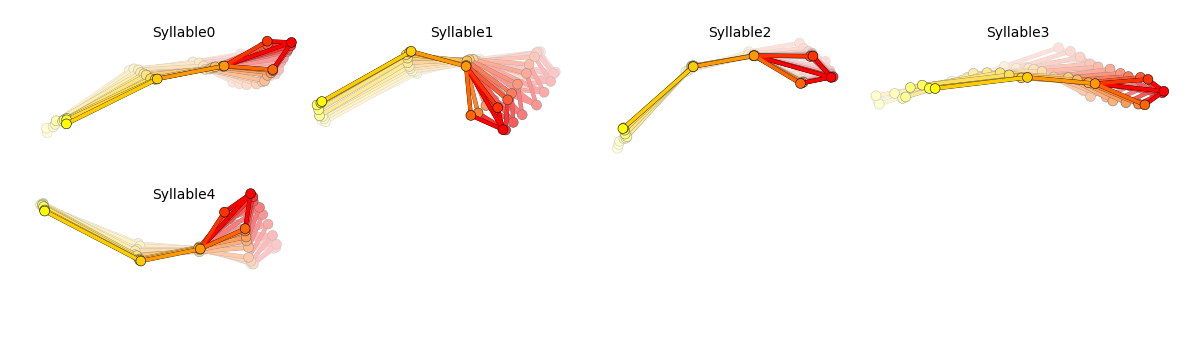

In [31]:
# Trajectory plots
results = kpms.load_results(project_dir, model_name)
kpms.generate_trajectory_plots(coordinates, results, project_dir, model_name, **config())

In [33]:
# Grid movies
kpms.generate_grid_movies(results, project_dir, model_name, coordinates=coordinates, **config());

/home/sminano/miniconda3/envs/keypoint_moseq/lib/python3.9/site-packages/keypoint_moseq/viz.py:1266: UserWarning:


Videos will be downscaled by a factor of 0.87 so that the grid movies
are under 1920 pixels. Use `max_video_size` to increase or decrease
this size limit.





Writing grid movies to /home/sminano/swc/project_teaching_behaviour/mouse-EPM-moseq/2024_08_16-15_21_45/grid_movies
Using window size of 368 pixels


Generating grid movies: 100%|█████████████| 8/8 [00:33<00:00,  4.18s/it]


In [37]:
# Syllable dendrogram
# kpms.plot_similarity_dendrogram(coordinates, results, project_dir, model_name, **config())

/home/sminano/miniconda3/envs/keypoint_moseq/lib/python3.9/site-packages/keypoint_moseq/util.py:1104: RuntimeWarning:

All-NaN slice encountered



ValueError: Distance matrix 'X' must be symmetric.

In [ ]:
# Apply to new data